In [149]:
import numpy as np
import cv2
import torch
import os
import matplotlib.pyplot as plt
import imutils

In [2]:
from keypoint_model import keypoint_model

In [43]:
def get_image(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
def get_classifier(data_dir, file_name):
    path = os.path.join(data_dir, file_name)
    classifier = cv2.CascadeClassifier(path)
    return classifier

In [4]:
def convert_image_to_bw(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    return image

In [108]:
def detect_faces(classifier, image):
#     bw_image = convert_image_to_bw(image)
    rects = classifier.detectMultiScale(image, 1.2, 2)
#     for x, y, w, h in rects:
#         cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return rects

In [136]:
def detect_keypoints(model, image, faces, padding = 50):
    image_copy = image.copy()
    img_height, img_width = image.shape[0], image.shape[1]
    images, keypoints = [], []
    for coords in faces:
        img = image[max(0, coords[1]-padding): min(coords[1]+coords[-1]+padding, img_height), 
                    max(0, coords[0]-padding): min(coords[0]+coords[2]+padding, img_width)]
        img = (img/255.0).astype(np.float32)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=0)
        else:
            img = np.rollaxis(img, 2, 0)
        img = np.expand_dims(img, axis=0)
        img = torch.from_numpy(img).type(torch.FloatTensor)
        results = model.forward(img)
        results = results.view(results.size()[0], 68, -1).cpu()
        pred = results[0].cpu().data
        pred = pred.numpy()
        pred = pred * 50 + 100
        keypoints.append(pred)
    return images, keypoints

In [137]:
model = keypoint_model()
model.load_state_dict(torch.load("./models/keypoint_detection_model.pth", map_location='cpu'))
model.eval()
classifier = get_classifier(data_dir="./models", file_name="face_detection_model.xml")

In [336]:
image = get_image(data_dir="./images", file_name="girl.jpg")
faces = detect_faces(classifier=classifier, image=image)

In [337]:
images, keypoints = detect_keypoints(faces=faces, image=image, model=model, padding=50)

In [338]:
def visualize_output(faces, test_outputs):  
    for i, face in enumerate(faces):
        plt.figure(figsize=(5, 5))
        plt.imshow(face)
        plt.scatter(test_outputs[i][:, 0], test_outputs[i][:, 1], s=20, marker='.', c='m')
        plt.axis('off')
    plt.show()

In [339]:
def apply_sunglasses(face, sg_image, keypoints):
    eyebrow_height_diff = abs(keypoints[17, 1] - keypoints[26, 1])
    eyebrow_width = abs(keypoints[17, 0] - keypoints[26, 0])
    eyebrow_angle = np.arctan(eyebrow_height_diff/eyebrow_width)*(180/np.pi)
    eyebrow_angle = eyebrow_angle if keypoints[17, 1] < keypoints[26, 1] else -eyebrow_angle
    
    rotated_sunglasses = imutils.rotate_bound(sg_image, eyebrow_angle)
    y = int(min(keypoints[17, 1], keypoints[26, 1]))
    h = abs(keypoints[51, 1]-keypoints[27, 1])
    w = abs((keypoints[16, 0]+keypoints[26, 0])/2 - (keypoints[17, 0]+keypoints[0, 0])/2)
    top_nose = keypoints[27]
    rectangle_sunglasses = face[y:int(y+h), int(top_nose[0]-w/2):int(top_nose[0]+w/2)]
    new_sunglasses = cv2.resize(rotated_sunglasses, (int(w), int(h)), interpolation = cv2.INTER_CUBIC)
    ind = np.argwhere(new_sunglasses[:,:,3] > 0) 
    for i in range(3):
        rectangle_sunglasses[ind[:, 0], ind[:, 1], i] = new_sunglasses[ind[:, 0], ind[:, 1], i]
    return face

In [340]:
def apply_dog_filter(face, filt):
    filt_h, filt_w, _ = filt.shape
    face_h, face_w, _ = face.shape
    factor = min(face_h/filt_h, face_w/filt_w)
    new_filt_h, new_filt_w = int(filt_h*factor), int(filt_w*factor)
    new_filt_shape = (new_filt_w, new_filt_h)
    resized_filter = cv2.resize(filt, new_filt_shape)
    masked_face = face.copy()
    non_white_pixels = (resized_filter < 250).all(axis = 2)
    offset_h, offset_w = int((face_h-new_filt_h)/2), int((face_w-new_filt_w)/2)
    masked_face[offset_h:offset_h+new_filt_h, offset_w:offset_w+new_filt_w][non_white_pixels] = resized_filter[non_white_pixels]
    return masked_face

In [364]:
dog_filter = cv2.imread("./filters/dog.png")

In [365]:
def dog_face_filter(image, classifier, dog_filter):
    image_h, image_w = image.shape[0], image.shape[1]
    rectangles = detect_faces(classifier=classifier, image=image)
    for x, y, w, h in rectangles:
        y0, y1 = int(y - 0.25*h), int(y + 0.75*h)
        x0, x1 = x, x + w
        if x0 < 0 or y0 < 0 or x1 > image_w or y1 > image_h:
            continue
        image[y0: y1, x0: x1] = apply_dog_filter(image[y0: y1, x0: x1], dog_filter)
    return image

In [366]:
dog_filtered_image = dog_face_filter(image.copy(), classifier, dog_filter)

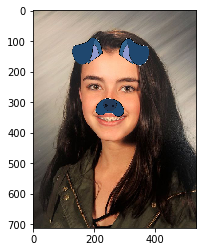

In [367]:
plt.imshow(dog_filtered_image)